# desc-wfmon/monexp.ipynb: Monitor explorer example

We use the classes in desc-wfmon to view monitoring data from DESC gen3 parsl jobs.

Typically, this file is copied to the area where the jobs were run.

First setup to use the local install area and then import the the system (sysmon) and process (wfmon) explorers. 

See desc-wfmon/install.ipynb to install that package in the local directory and create the setup on the first line. 

In [1]:
print('Notebook version is 6.0')
import sys
import os
import datetime
homedir = os.getenv('HOME')
print(f"Current directory is {os.getcwd()}")
stzone = datetime.datetime.utcnow().astimezone().tzinfo
print(f"Local time zone is {stzone}")
srcdir = f"{homedir}/desc/dev"
nbdir = srcdir + '/desc-wfmon/ipynb'
%run $nbdir/setup.ipynb
print('Checking for local install of desc-wfmon')
%run install/setup.py
print(f"Python version is {sys.version}")
print(f"Python search path starts with {sys.path[0]}:{sys.path[1]}:{sys.path[2]}")
!pwd
import pandas
import numpy
import matplotlib.pyplot as plt
import matplotlib.colors as pltcol
import desc.wfmon
import desc.sysmon
for pkg in [desc.wfmon, desc.sysmon]:
    print(f"{pkg} version is {pkg.__version__}")


Notebook version is 5.3
Current directory is /global/u2/d/dladams/desc/rundirs/ptest60-wq-pmcp-cvmfs-001
Local time zone is PDT
login27:/global/u2/d/dladams/desc/rundirs/ptest60-wq-pmcp-cvmfs-001: Fri 17 Jun 2022 09:08:20 AM PDT
Setting up desc-wfmon
Installing up desc-wfmon
bootstrap: Installing descr-wfmon.
Installing /global/homes/d/dladams/desc/dev/desc-wfmon at ./install/noconda
Processing /global/homes/d/dladams/desc/dev/desc-wfmon


  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for desc-wfmon: filename=desc_wfmon-0.9.3.dev2-py3-none-any.whl size=37694 sha256=a9e34c5e04cef22bd910edbc5ea59bb933d4c15c55e114961401dd15fe9450fb
  Stored in directory: /global/u2/d/dladams/.cache/pip/wheels/8c/c4/a7/e0f7d35d0abda943febbfb967d473d73927ae1840007e59d62
Successfully built desc-wfmon
bootstrap: Package desc-wfmon is installed at ./install/noconda
Done
Python version is 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
Python search path starts with ./install/noconda
/global/u2/d/dladams/desc/rundirs/ptest60-wq-pmcp-cvmfs-001
TestMonDbReader:ctor: Done.
<module 'desc.wfmon' from '/global/u2/d/dladams/desc/rundirs/ptest60-wq-pmcp-cvmfs-001/./install/

## Configuration
Define some useful constants and specify the location of the monitoring data files. Set dir to point to your area.

In [2]:
# Read the config.
%run monexp.py

# Defaults for configuration.
class monexp_def:
    dir = os.getcwd()
    name = os.path.basename(os.getcwd())
    stunit = 'minute'         # Unit for time axes
    sbunit = 'gb'             # Unit for memory, I/O
    tmin = 0                  # Min time for time axes
    tmax = 20                 # Max time for time axes
    taskrunmax = 130          # Max for running task axes
    tasktimemax = 200         # Max for time/task axis [s]
    taskcount_interval = 10   # Sampling interval for evaluating try task counts
    tzoff = 0                 # Time zone offset between system and process monitors
    tlatencymax = 20          # Max for latency axis
    tlatrunmax = 100          # Max for lataency + run time        
    
# Set defaults for any missing parameters.
if 'monexp' not in dir():
    monexp = monexp_def
else:
    for nam in monexp_def.__dict__:
        if nam[0:2] == '__': continue
        if not hasattr(monexp, nam):
            setattr(monexp, nam, getattr(monexp_def, nam))
        
# Time conversions and plotting units.
tunits = {'second':1, 'minute':60, 'hour':3600, 'day':24*3600}
stunit = monexp.stunit
tunit = tunits[stunit]

# Memory and I/O conversion plotting units.
bunits = {'mb':2**20, 'gb':2**30}
gb = bunits['gb']
sbunit = monexp.sbunit
bunit = bunits[sbunit]
bunit_sys = bunit/gb

# Time range for the plots
# if tmax <= tmin, it will be reset with the data below
tmin = monexp.tmin
tmax = monexp.tmax

print("Time zone offset: {monexp.tzoff} sec")

# Plot size
pdx = 20
pdy = 6

line = '-----------------------------------------------------------'
fread = monexp.dir + '/README.txt'
if os.path.exists(fread):
    fin = open(fread, 'r')
    #readme = fin.read().strip()
    readme = fin.readlines()
    with open(fread) as fin:
        readme = [line.rstrip() for line in fin]
else:
    raise Exception('README.txt not found')
print('README:')
for line in readme: print(line)
pttl = monexp.name + ": " + readme[0]
print(f"Plot title: {pttl}")
pfx = monexp.name
print(f"Plot file prefix: {pfx}")
sfx = '.png'
print(f"Plot file suffix: {sfx}")
plt.rc('font', size=16)
plt.rc('savefig', facecolor='white', bbox='tight')
plt.rc('axes', titlesize='medium')

Time zone offset: {monexp.tzoff} sec
README:
14Jun2022 Parsltest on nid005815 with 5000 (20 sec, 10 GB) tasks, WorkQueue with 100 workers, 5 sec sampling

ptest60-wq-pmcp-cvmfs-001
Plot title: ptest60-wq-pmcp-cvmfs-001: 14Jun2022 Parsltest on nid005815 with 5000 (20 sec, 10 GB) tasks, WorkQueue with 100 workers, 5 sec sampling
Plot file prefix: ptest60-wq-pmcp-cvmfs-001
Plot file suffix: .png


## Fetch system-level monitoring data

System level monitoring data is collected using *desc.sysmon*. The data is in csv format and is read here with *pandas*.

The column names follow from those of the corresponding *psutil* variables.

We fetch the number of CPUs and total memory and check both are consistent for all samples.

In [3]:
sym = pandas.read_csv(monexp.dir + '/sysmon.csv')
print(f"System monitor sample count: {len(sym)}")
print(f"System monitor columns:")
for cnam in sym.columns:
    print(f"  {cnam}")

assert(len(sym.cpu_count.unique()) == 1)
ncpu = sym.cpu_count[0]
print(f"CPU count is {ncpu:.0f}")

assert(len(sym.mem_total.unique()) == 1)
maxmem = sym.mem_total[0]/bunit_sys
print(f"Total memory is {maxmem:.1f} {sbunit}")


System monitor sample count: 260
System monitor columns:
  time
  cpu_count
  cpu_percent
  cpu_freq
  cpu_user
  cpu_system
  cpu_idle
  cpu_iowait
  cpu_time
  mem_total
  mem_available
  mem_swapfree
  dio_readsize
  dio_writesize
  nio_readsize
  nio_writesize
CPU count is 256
Total memory is 503.2 gb


## Fetch the process-level monitoring data

The process monitoring data is read from the mysql DB produced by parsl. Of particular interest is the task table where metrics are sampled at regular intervals seprately for each job.

We "fix" that data to make it more amenable for analysis. Among many other modifications, fixing converts time strings to integers and add a procsum (process summary) table which sums the contributions from all jobs. Although the sampling interval is the same for all jobs, they have different offsets and so there is some ambiguity in this summing.

For disk and network I/O, integrated values are recorded but the differential values (the amount read or written each sampling interval) are of interest here. A separate call is made to build a procsum table that includes these differential values. This is not done automatically because it can be slow.

In [4]:
for subdir in ['', '/runinfo']:
    fnam = f"{monexp.dir}{subdir}/monitoring.db"
    if os.path.exists(fnam):
        dbr = desc.wfmon.MonDbReader(fnam, dodelta=True)
print(f"Label: {pttl}")
dbr.tables(2)

Label: ptest60-wq-pmcp-cvmfs-001: 14Jun2022 Parsltest on nid005815 with 5000 (20 sec, 10 GB) tasks, WorkQueue with 100 workers, 5 sec sampling
DB /global/u2/d/dladams/desc/rundirs/ptest60-wq-pmcp-cvmfs-001/runinfo/monitoring.db has 9 tables
*******************************************************
Table workflow has 1 rows and 9 columns
Column names:
     int64   run_idx
     int64   wf_idx
   float64   time_began
   float64   time_completed
    object   host
    object   user
    object   rundir
     int64   tasks_failed_count
     int64   tasks_completed_count
*******************************************************
Table task has 5000 rows and 15 columns
Column names:
     int64   task_id
     int64   run_idx
    object   task_depends
     int64   task_idx
    object   task_memoize
    object   task_hashsum
    object   task_inputs
    object   task_outputs
    object   task_stdin
    object   task_stdout
    object   task_stderr
   float64   task_time_invoked
   float64   task_time_re

## Run selection
Define handles for the process tables of interest:

* prc - Process table holds sampled data for each process
* psm - Process summary table (procsum) holds samples summed over all processes

If the process monitor includes more than one run, then select one run to study here.

In [5]:
nrun = len(dbr.table('workflow'))
if nrun == 1:
    print('One run found.')
    wkf = dbr.table('workflow')
    tsk = dbr.table('task')
    tst = dbr.table('try')
    prc = dbr.table('resource')
    psm = dbr.table('procsum')
else:
    rqry = 'run_idx==0'
    print(f"Selecting runs with {rqry}")
    wkf = dbr.table('workflow').query(rqry)
    tsk = dbr.table('task').query(rqry)
    tst = dbr.table('try').query(rqry)
    prc = dbr.table('resource').query(rqry)
    psm = dbr.table('procsum').query(rqry)
print(f"Process table entry count: {len(prc)}")
print(f"Procsum table entry count: {len(psm)}")
print(f" System table entry count: {len(sym)}")
have_procsum = len(psm) > 0

One run found.
Process table entry count: 28861
Procsum table entry count: 257
 System table entry count: 260


## Time range

For convenience we add a column tfix to each table that converts to units defined above.  
The time offset used in the process tables is applied to the system table. A configureable offset is also added, e.g. to account for time zone issues.

## Tasks
We look at the task types, how many of each were run and plot the distribution of run times for the tasks.

In [6]:
t0sec = dbr.t0 + monexp.tzoff
delt = dbr.monitoring_interval
if delt is None : delt = 0.0
deltsys = (max(sym.time) - min(sym.time))/float(len(sym) - 1)

wkf['tfix_began'] = wkf.time_began/tunit
wkf['tfix_completed'] = wkf.time_completed/tunit
tst['trun'] = tst.task_try_time_returned - tst.task_try_time_running
tst['tfix_launched'] = tst.task_try_time_launched/tunit
tst['tfix_running'] = tst.task_try_time_running/tunit
tst['tfix_returned'] = tst.task_try_time_returned/tunit
tsk['tfix_invoked'] = tsk.task_time_invoked/tunit
prc['tfix'] = prc.timestamp/tunit
if have_procsum:
    psm['tfix'] = psm.timestamp/tunit
sym['tfix'] = (sym.time - t0sec)/tunit

twkf1 = wkf.tfix_began.min()
twkf2 = wkf.tfix_completed.max()
tlau1 = tst.tfix_launched.min()
tlau2 = tst.tfix_launched.max()
tinv1 = tsk.tfix_invoked.min()
tinv2 = tsk.tfix_invoked.max()
tprc1 = prc.tfix.min()
tprc2 = prc.tfix.max()
if have_procsum:
    tpsm1 = psm.tfix.min()
    tpsm2 = psm.tfix.max()
tsym1 = sym.tfix.min()
tsym2 = sym.tfix.max()
if tmax <= tmin:
    tmax = 1.01*tprc2

print(f"  Proc time interval: {delt:.2f} sec")
print(f"   Sys time interval: {deltsys:.2f} sec")
print(f" Workflow time range: ({twkf1:.2f}, {twkf2:.2f}) {stunit}")
print(f"   Invoke time range: ({tinv1:.2f}, {tinv2:.2f}) {stunit}")
print(f"   Launch time range: ({tlau1:.2f}, {tlau2:.2f}) {stunit}")
print(f"  Process time range: ({tprc1:.2f}, {tprc2:.2f}) {stunit}")
if have_procsum:
    print(f"  Procsum time range: ({tpsm1:.2f}, {tpsm2:.2f}) {stunit}")
print(f"   System time range: ({tsym1:.2f}, {tsym2:.2f}) {stunit}")
print(f" Plotting time range: ({ tmin:.2f}, { tmax:.2f}) {stunit}")

  Proc time interval: 5.00 sec
   Sys time interval: 5.05 sec
 Workflow time range: (0.00, 22.84) minute
   Invoke time range: (0.00, 1.47) minute
   Launch time range: (0.00, 1.47) minute
  Process time range: (0.05, 21.47) minute
  Procsum time range: (0.04, 21.38) minute
   System time range: (-0.00, 21.82) minute
 Plotting time range: (0.00, 30.00) minute


         Task idx count: 1
             Task count: 5000
      Unique task count: 5000
              Try count: 5000
         Try done count: 5000
  Max task by tid count: 5000

Task name [done/count]
   0: mybash_ifix [5000/5000/5000] 21.7


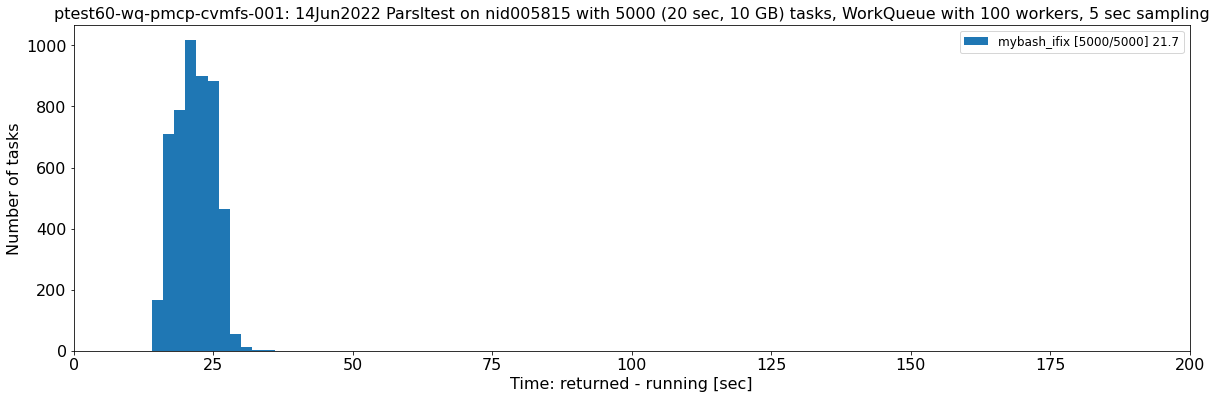

In [7]:
tsk = dbr.table('task')
tsy = dbr.table('try')
ntsk = len(tsk)
ntid = len(tsk.task_idx.unique())
ntry = len(tsy)
trunMax = (tsy.task_try_time_running - tsy.task_try_time_launched).dropna().max()
tsyDone = tsy.query("task_try_time_returned==task_try_time_returned")
ntryDone = len(tsyDone)
ntskByTid = []
for itid in range(ntid):
    ntskByTid.append(len(tsk.query(f"task_idx=={itid}")))
ntskByTidMax = max(ntskByTid)
print(f"         Task idx count: {ntid}")
print(f"             Task count: {ntsk}")
print(f"      Unique task count: {len(tsk.task_id.unique())}")
print(f"              Try count: {ntry}")
print(f"         Try done count: {ntryDone}")
print(f"  Max task by tid count: {ntskByTidMax}")

print()
print("Task name [done/count]")
assert(ntid == len(dbr.task_names))
tsyDoneByTask = [None]*ntid
for itid in range(ntid):
    tsyDoneByTask[itid] = tsyDone.query(f"task_idx=={itid}")
    t1 = tsyDoneByTask[itid].task_try_time_running
    t2 = tsyDoneByTask[itid].task_try_time_returned
    nrun = t1.count()
    ndone = t2.count()      # count ignores NaN
    if nrun != ndone:
        savg = f"ERROR: nrun={nrun} != ndone={ndone}"
    elif len(t2):
        avg = (t2-t1).mean()
        savg = f" {avg:.1f}"
    else:
        savg = ''
    print(f"{itid:4}: {dbr.task_names[itid]} [{ndone}/{nrun}/{dbr.task_name_counts[itid]}]{savg}")


x1 = 0
x2 = monexp.tasktimemax
# Fetch run times for each type of task
taskdts = [None]*ntid
cols = [None]*max(ntid,3)
ncol = len(cols)
labs = [None]*ntid
#mycols = ['red', 'green', 'orange', 'blue', 'yellow', 'violet', 'cyan', 'pink']
for itid in range(ntid):
    t1 = tsyDoneByTask[itid].task_try_time_running
    t2 = tsyDoneByTask[itid].task_try_time_returned
    if len(t2):
        avg = (t2-t1).mean()
        savg = f" {avg:.1f}"
    else:
        savg = ''
    taskdts[itid] = (t2-t1).clip(upper=0.999*x2)
    #cols[itid] = 'tab:' + mycols[itid%8]
    labs[itid] = f"{dbr.task_names[itid][0:20]} [{len(tsyDoneByTask[itid])}/{dbr.task_name_counts[itid]}]{savg}"
    #print(f"Color {cols[itid]}")
plt.figure(figsize=(pdx, pdy))
plt.hist(bins=100, range=(x1, x2), x=taskdts, stacked=True, label=labs)
plt.legend(loc="upper right", fontsize=12)
plt.xlabel('Time: returned - running [sec]')
plt.ylabel('Number of tasks')
junk = plt.xlim([x1, x2])
plt.title(pttl)
plt.savefig(pfx+'ttask'+sfx)

## Task states
Next look at when the tasks enter each of the three try states: launched, running and returned.  

The figure shows the (integrated) number of tasks completed as function of time for each task type.

        time     0   all       tfix
0        0.0     0     0   0.000000
1        1.0     0     0   0.016667
2        2.0     0     0   0.033333
3        3.0     0     0   0.050000
4        4.0     0     0   0.066667
...      ...   ...   ...        ...
1366  1366.0  5000  5000  22.766667
1367  1367.0  5000  5000  22.783333
1368  1368.0  5000  5000  22.800000
1369  1369.0  5000  5000  22.816667
1370  1370.0  5000  5000  22.833333

[1371 rows x 4 columns]
Run time is 22.8 minute


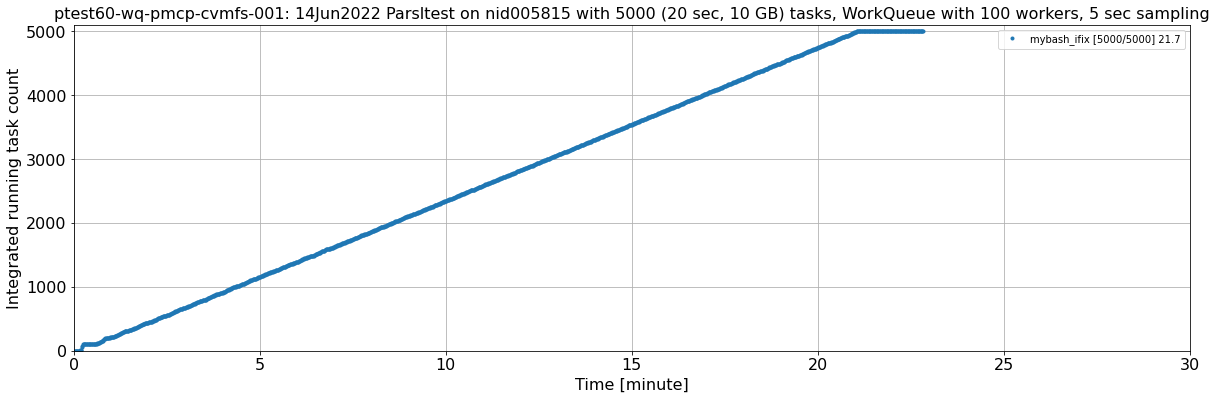

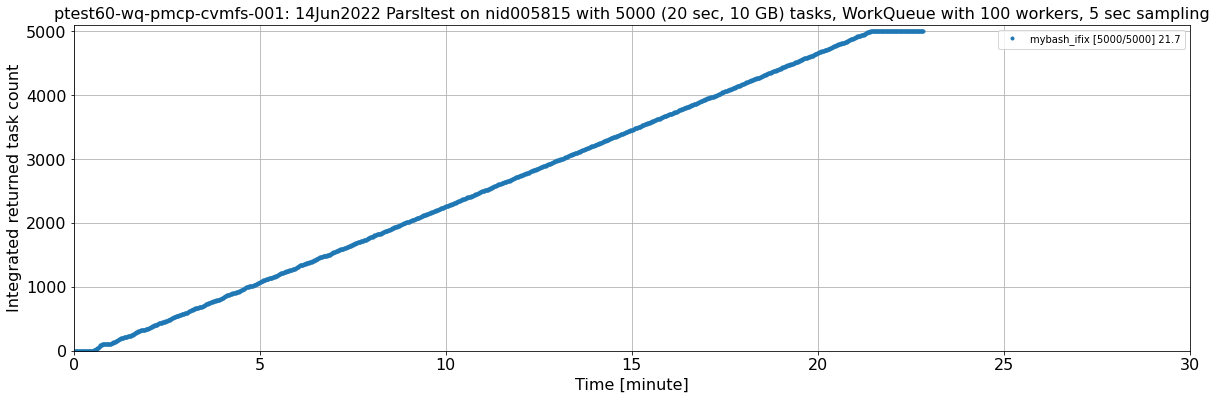

In [8]:
if tprc2 > 0.8*tmax:
    legloc = "upper left"
else:
    legloc = "upper right"
dbr.taskcounts(delt=monexp.taskcount_interval)
for dfs in dbr._taskcounts:
    for idf in dfs:
        dfs[idf]['tfix'] = dfs[idf].time/tunit
dbr._taskcounts[0]['running']
print(dbr.taskcounts('returned', 0))
state = 'running'
tsclau = dbr.taskcounts('launched')
tscrun = dbr.taskcounts('running')
tscret = dbr.taskcounts('returned')
tscact = tscrun - tscret   # Number of task running
tscmax = tscret.tfix.max()
print(f"Run time is {tscmax:.1f} {stunit}")
for sstat in ['running', 'returned']:
    plt.figure(figsize=(pdx, pdy))
    tsc = dbr.taskcounts(sstat)
    for itid in range(ntid):
        plt.plot(tsc.tfix, tsc[itid], '.', color=cols[itid%ncol], label=labs[itid])
    plt.xlabel(f"Time [{stunit}]")
    plt.ylabel(f"Integrated {sstat} task count")
    plt.legend(loc=legloc, fontsize=10)
    plt.grid(True)
    junk = plt.axis([tmin, tmax, 0, 1.02*ntskByTidMax])
    plt.title(pttl)
    plt.savefig(f"{pfx}sn{sstat[0:3]}{sfx}")
    plt.show()

## Throughput

This figure shows the total number of jobs launched, started and finished as function of time.

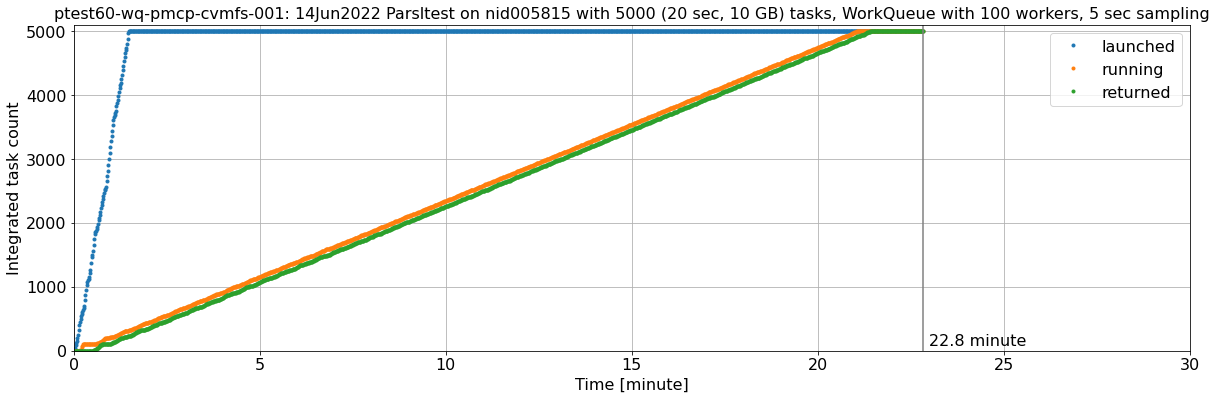

In [9]:
plt.figure(figsize=(pdx, pdy))
plt.plot(tscrun.tfix, tsclau['all'], '.', color=cols[0], label='launched')
plt.plot(tscrun.tfix, tscrun['all'], '.', color=cols[1], label='running')
plt.plot(tscrun.tfix, tscret['all'], '.', color=cols[2], label='returned')
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('Integrated task count')
plt.legend(loc=legloc)
plt.grid(True)
ymin = 0.0
ymax = 1.02*ntsk
junk = plt.axis([tmin, tmax, ymin, ymax])
if ntryDone == ntry and tscmax <= tmax:
    wx = tmax - tmin
    wy = ymax - ymin
    if tscmax > 0.8*tmax:
        ha = 'right'
        dx = -0.005*wx
    else:
        ha = 'left'
        dx = 0.005*wx
    plt.plot([tscmax, tscmax], [ymin, ymax], color='gray', linestyle='-')
    plt.text(tscmax + dx, ymin + 0.015*wy, f"{tscmax:.1f} {stunit}", ha=ha)
plt.title(pttl)
plt.savefig(pfx+'throughput'+sfx)

## Running jobs

We would like to know how many tasks were running as function of time.

We plot the difference between the number of tasks started and finished again using the try table.

Colors: [None, None, None]


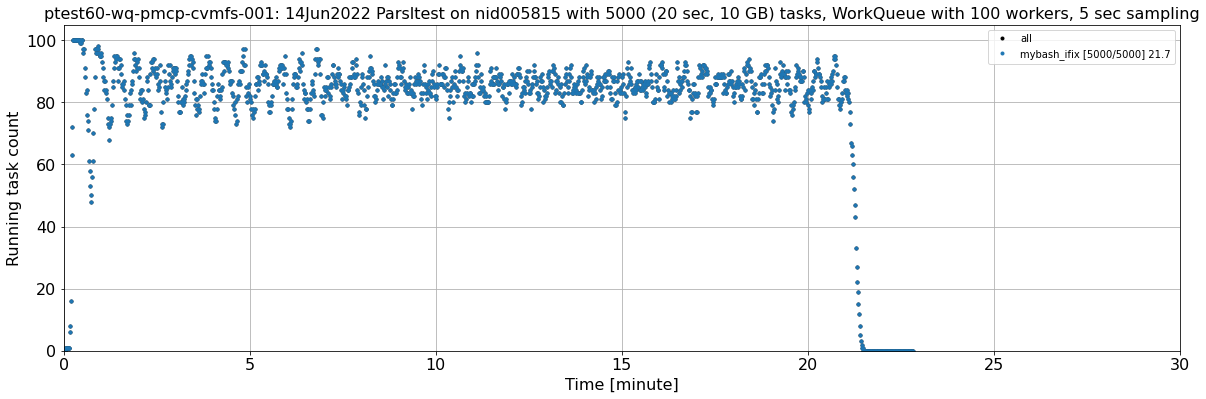

In [10]:
xmin = tmin
xmax = tmax
ymin = 0
ymax = monexp.taskrunmax
plt.figure(figsize=(pdx, pdy))
tscmem = (tscrun['all'] - tscret['all']).clip(upper=0.999*ymax)
plt.plot(tscrun.tfix, tscmem, '.', color='black', label='all')
for itid in range(ntid):
    plt.plot(tscret.tfix, tscrun[itid] - tscret[itid], '.', color=cols[itid%ncol], label=labs[itid])
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('Running task count')
plt.legend(fontsize=10)
plt.title(pttl)
#plt.setp(plt.gca().get_legend().get_texts(), fontsize='8')
plt.grid(True)
junk = plt.axis([xmin, xmax, ymin, ymax])
plt.title(pttl)
plt.savefig(pfx+'nruntask'+sfx)
print(f"Colors: {cols}")

The procsum table also provides the count of jobs running at any time and its totla is compared with that from the try table in the figure below. Both are over time intervals and so offset my lead to slight differences between the two estimates. If one has longer intervals and that interval is comparable to or larger thatn the task run times, then this discrepancy can be large.

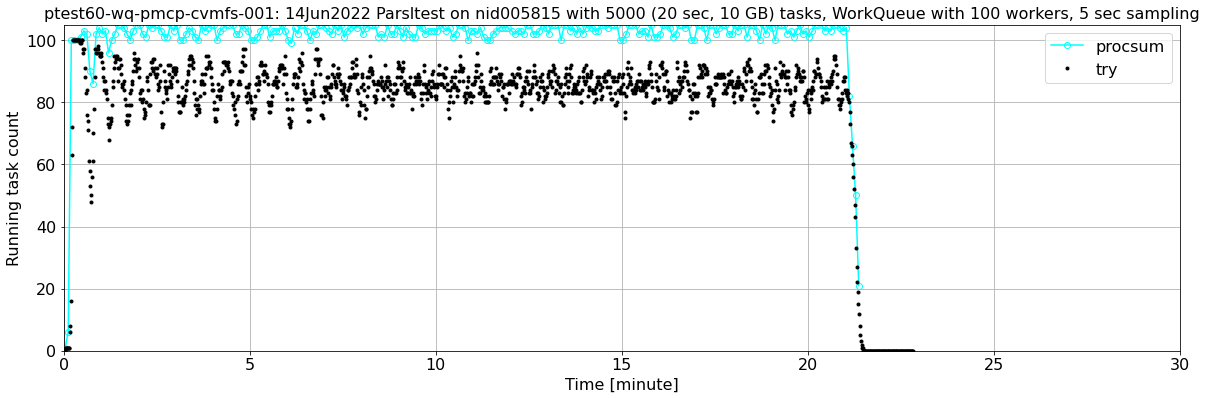

In [11]:
plt.figure(figsize=(pdx, pdy))
if have_procsum:
    plt.plot(psm.tfix, psm.nproc.clip(upper=ymax), color='cyan', marker='o', fillstyle='none', label='procsum')
plt.plot(tscrun.tfix, tscmem, '.', color='black', label='try')
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('Running task count')
plt.legend()
plt.grid(True)
junk = plt.axis([tmin, tmax, ymin, ymax])
plt.title(pttl)
plt.savefig(pfx+'nruncmp'+sfx)

## CPU utilization

The system monitor records the total CPU time and that in vaious states. Here we define CPU utilization as the fraction of time spent in the user
and sys (system time on  behalf of users). This is shown in red in the following plot.

The process monitor also records (and procsum sums) the total CPU time and the CPU time spent in these two states: *user* (executing user code) and *system* (performing system operations such as I/O on behalf of the user). The sum of these (*user*+*system*) divided by the total time is shown on the plot with blue markers.

We expect the system values to be larger because they include CPU used by the workflow and monitoring systems.

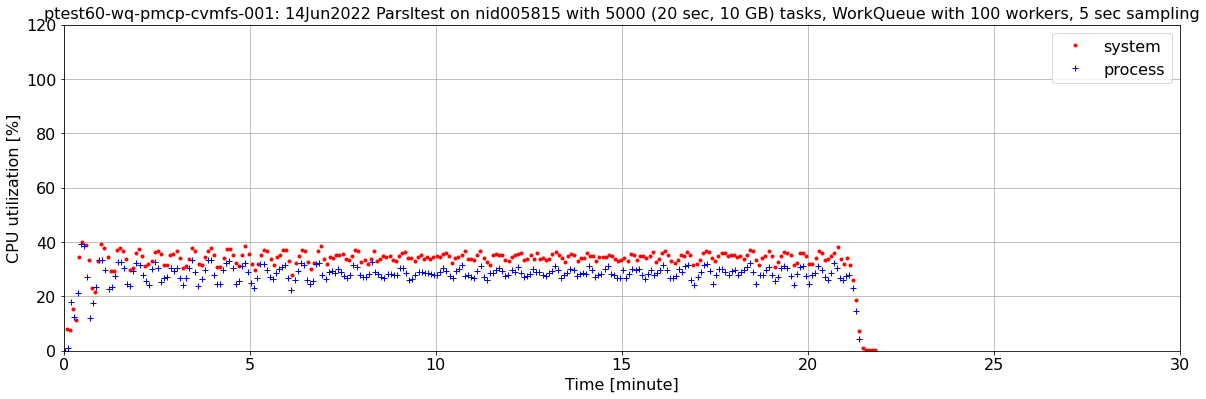

In [12]:
xmin = tmin
xmax = tmax
ymin = 0
ymax = 120
plt.figure(figsize=(pdx, pdy))
plt.plot(sym.tfix, sym.cpu_percent, '.', color='red', label='system')
# To get a process estimate, we divide the total user+sys time by the time interval and number of CPU.
if have_procsum:
    peff = 100*(psm.procsum_time_user+psm.procsum_time_system)/delt/ncpu
    plt.plot(psm.tfix, peff.clip(upper=0.999*ymax), 'b+', label='process')
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('CPU utilization [%]')
plt.grid(True)
plt.legend()
junk = plt.axis([xmin, xmax, ymin, ymax])
plt.title(pttl)
plt.savefig(pfx+'cpueff'+sfx)

## Task count and utilization
Here we overlay the task count with the utilization summed over CPUs.


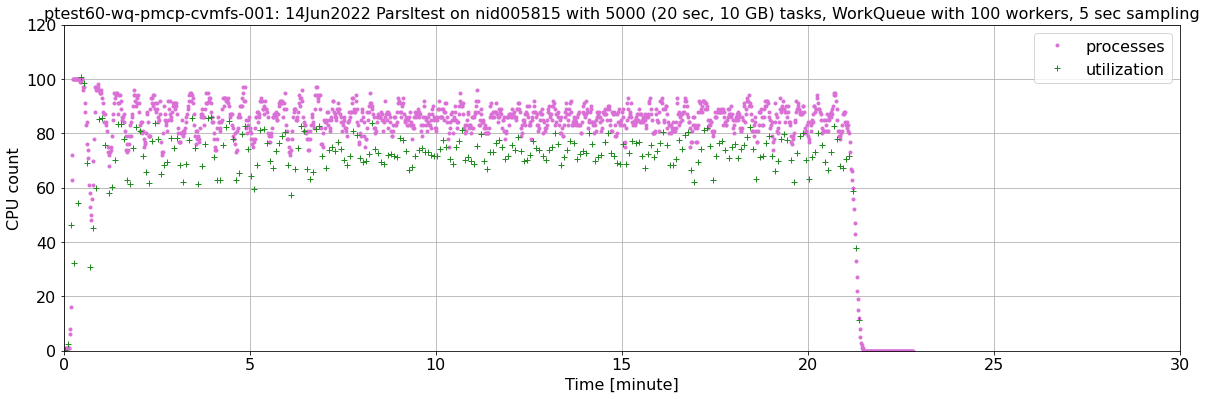

In [13]:
xmin = tmin
xmax = tmax
ymin = 0
ymax = 120
plt.figure(figsize=(pdx, pdy))
plt.plot(tscrun.tfix, tscmem, '.', color='orchid', label='processes')
# To get a process estimate, we divide the total user+sys time by the time interval and number of CPU.
if have_procsum:
    puse = (psm.procsum_time_user+psm.procsum_time_system)/delt
    plt.plot(psm.tfix, puse.clip(upper=0.999*ymax), color='forestgreen', marker='+', linestyle='None', label='utilization')
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('CPU count')
plt.grid(True)
plt.legend()
junk = plt.axis([xmin, xmax, ymin, ymax])
plt.title(pttl)
plt.savefig(pfx+'cpucount'+sfx)

## Memory usage

Check sizes: 260 == 260 == 260
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


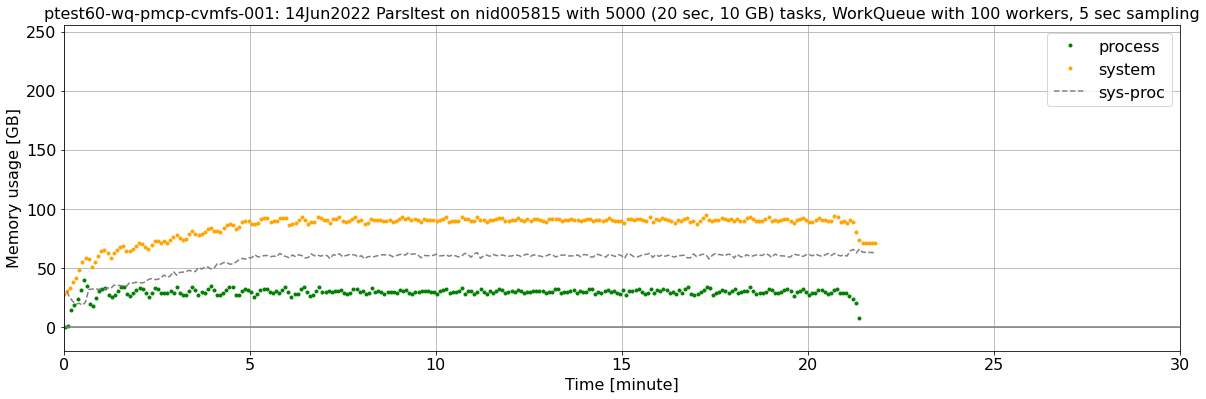

In [14]:
# First build psm2 which holds values with the same times as sym soe
# we can look at the difference between the two.
newidx = sym.tfix
if have_procsum:
    psm2 = psm[['tfix', 'procsum_memory_resident']].set_index('tfix', drop=False)
    psm2 = psm2.reindex(psm2.index.union(newidx))
    psm2.interpolate('index', inplace=True)
    psm2 = psm2.reindex(index=sym.tfix)
    psm2['tfix'] = psm2.index
    psm2 = psm2.set_index(sym.index)
# Now make the figure
plt.figure(figsize=(pdx, pdy))
ymin = -20
ymax = 256
xmin = tmin
xmax = tmax
smemtot = (sym.mem_total/bunit_sys).clip(lower=ymin, upper=ymax)
smem = ((sym.mem_total - sym.mem_available)/bunit_sys).clip(lower=ymin, upper=ymax)
if have_procsum:
    pmem = psm.procsum_memory_resident/gb
    pmem2 = psm2.procsum_memory_resident/gb
    diff = smem - pmem2
    print(f"Check sizes: {len(smem)} == {len(pmem2)} == {len(diff)}")
    print(type(smem), type(pmem2))
if have_procsum:
    plt.plot(psm.tfix, pmem, 'g.', label='process')
plt.plot(sym.tfix, smem, '.', color='orange', label='system')
if have_procsum:
    plt.plot(newidx, diff, '--', color='gray', label='sys-proc')
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('Memory usage [GB]')
plt.legend()
plt.grid(True)
if ymin*ymax < 0.0:
    plt.plot([xmin, xmax], [0,0], '-', color='gray')
junk = plt.axis([xmin, xmax, ymin, ymax])
plt.title(pttl)
plt.savefig(pfx+'mem'+sfx)

## I/O rates

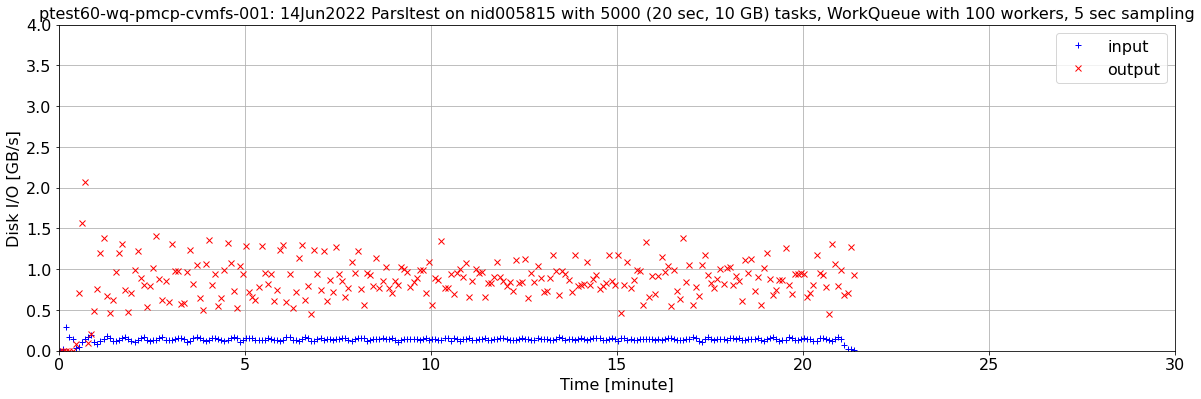

In [15]:
if have_procsum:
    plt.figure(figsize=(pdx, pdy))
    plt.plot(psm.tfix, psm.procsum_disk_read/gb/delt, 'b+', label='input')
    plt.plot(psm.tfix, psm.procsum_disk_write/gb/delt, 'rx', label='output')
    plt.xlabel(f"Time [{stunit}]")
    plt.ylabel('Disk I/O [GB/s]')
    plt.grid(True)
    plt.legend(loc="upper right")
    junk = plt.axis([tmin, tmax, 0, 4])
    plt.title(pttl)
    plt.savefig(pfx+'io'+sfx)
    plt.show()

(0.0, 30.0, 0.0, 1000.0)


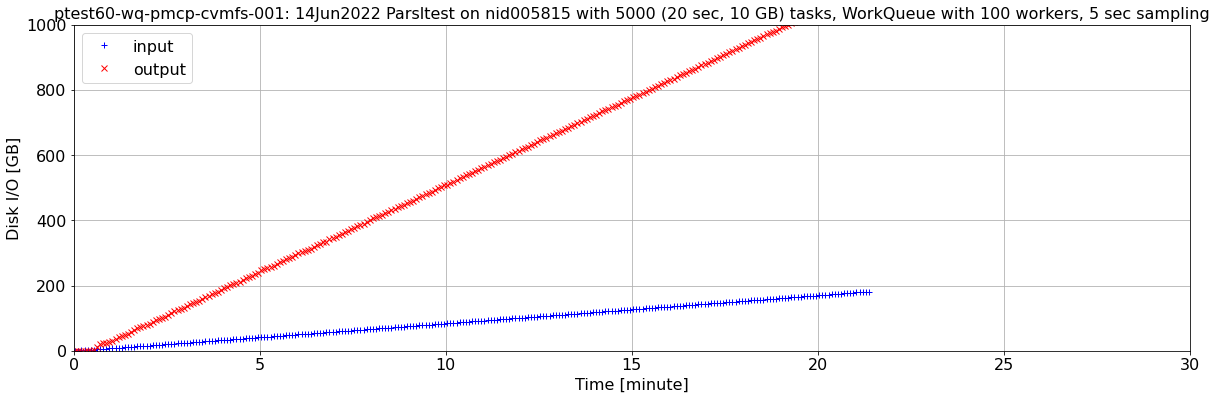

In [16]:
if have_procsum:
    xmin = tmin
    xmax = tmax
    ymin = 0.0
    ymax = 1000
    plt.figure(figsize=(pdx, pdy))
    plt.plot(psm.tfix, psm.procsum_disk_read.cumsum()/gb, 'b+', label='input')
    plt.plot(psm.tfix, psm.procsum_disk_write.cumsum()/gb, 'rx', label='output')
    plt.xlabel(f"Time [{stunit}]")
    plt.ylabel('Disk I/O [GB]')
    plt.grid(True)
    plt.legend(loc="upper left")
    junk = plt.axis([xmin, xmax, ymin, ymax])
    print(junk)
    plt.title(pttl)
    plt.savefig(pfx+'io2'+sfx)
    plt.show()
    #print(plt.rcParams)

## Latency
Task submission latency is evaluated by assigning tasks to chains and defining the latency as the time between the end of one task and start of the next in a chain.
This latency estimate is suspect if the executor runs a variable number of workers.
For a fixed value, there is one chain per worker.

  Total chain count: 100
   Late chain count: 0
       Mean latency: 3.58 sec


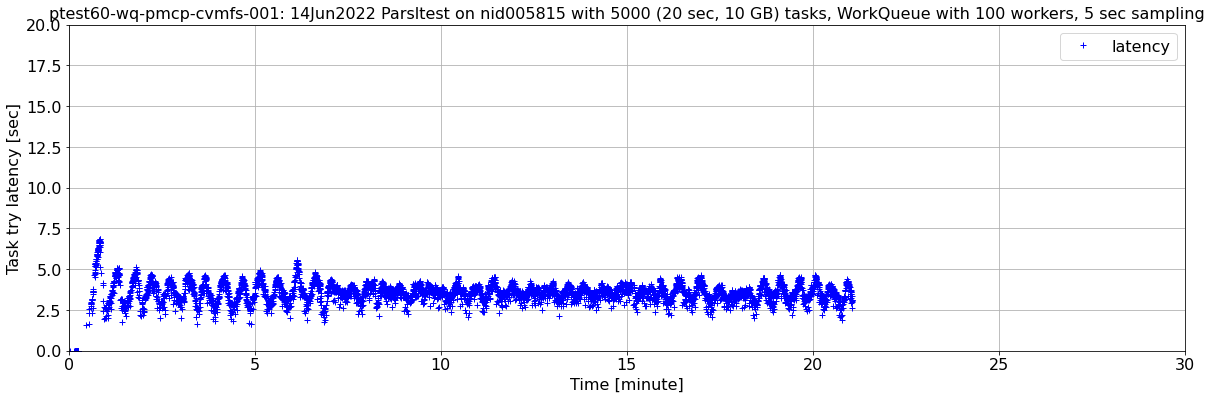

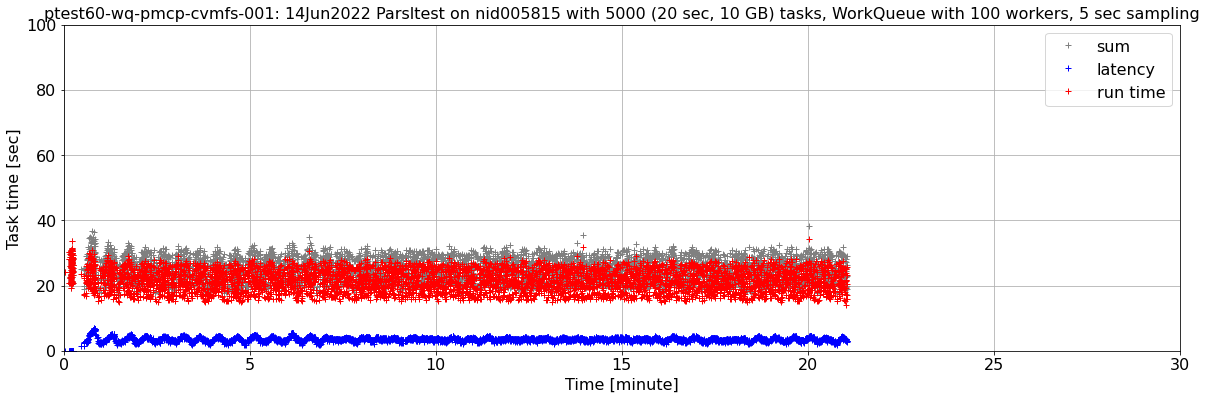

      last_try  next_try   latency
0          NaN    1212.0  0.000000
1          NaN    1901.0  0.000000
2          NaN    2064.0  0.000000
3          NaN    2200.0  0.000000
4          NaN    1897.0  0.000000
...        ...       ...       ...
4995    3564.0    4883.0  2.966648
4996    3717.0    4891.0  2.969859
4997    3434.0    4895.0  2.126297
4998    3240.0    4893.0  2.498982
4999    3562.0    4897.0  2.665396

[5000 rows x 3 columns]


In [17]:
dbr.chaintasks()
print(f"  Total chain count: {dbr.taskchain_count('all')}")
print(f"   Late chain count: {dbr.taskchain_count('late')}")
print(f"       Mean latency: {tst.latency.mean():.2f} sec")
if dbr.taskchain_count():
    ymin = 0
    ymax = monexp.tlatencymax
    tsklat = tst.latency.clip(0,0.995*ymax)
    plt.figure(figsize=(pdx, pdy))
    plt.plot(tst.tfix_running, tsklat, 'b+', label='latency')
    plt.xlabel(f"Time [{stunit}]")
    plt.ylabel('Task try latency [sec]')
    plt.grid(True)
    plt.legend(loc="upper right")
    junk = plt.axis([tmin, tmax, ymin, ymax])
    plt.title(pttl)
    plt.savefig(pfx+'latency_vs_time'+sfx)
    plt.show()
    # Latency and run time
    ymin = 0
    ymax = monexp.tlatrunmax
    tsklat = tst.latency.clip(0,0.995*ymax)
    tskrun = tst['trun'].clip(0,0.995*ymax)
    tsksum = (tst.latency+tst.trun).clip(0,0.995*ymax)
    plt.figure(figsize=(pdx, pdy))
    plt.plot(tst.tfix_running, tsksum, color='gray', marker='+', linestyle='None', label='sum')
    plt.plot(tst.tfix_running, tsklat, 'b+', label='latency')
    plt.plot(tst.tfix_running, tskrun, 'r+', label='run time')
    plt.xlabel(f"Time [{stunit}]")
    plt.ylabel('Task time [sec]')
    plt.grid(True)
    plt.legend(loc="upper right")
    junk = plt.axis([tmin, tmax, ymin, ymax])
    plt.title(pttl)
    plt.savefig(pfx+'latrun_vs_time'+sfx)
    plt.show()
print(tst[['last_try','next_try','latency']])